# Creating " word fields" for important parts-of-speech

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from umap import UMAP
from sklearn.cluster import OPTICS

from extract import *

with open('features/version1.pkl', 'rb') as p:
    features = pickle.load(p)

word2vec = LegalVectors()
vocabulary = {'N' : {'word' : [], 'vec' : []}, 'V' : {'word' : [], 'vec' : []}, 'S' : {'word' : [], 'vec' : []}, 'A' : {'word' : [], 'vec' : []}}
phrase2vec = {}

In [7]:
for chf in features:

    for n in chf.context_symbolic.nouns:
        if n not in vocabulary['N']['word']:
            vocabulary['N']['word'].append(n)
            vocabulary['N']['vec'].append(word2vec[n])

    for v in chf.context_symbolic.verbs:
        if v not in vocabulary['V']['word']:
            vocabulary['V']['word'].append(v)
            vocabulary['V']['vec'].append(word2vec[v])

    for s in chf.context_symbolic.subjs:
        if s not in vocabulary['S']['word']:
            vocabulary['S']['word'].append(s)
            vocabulary['S']['vec'].append(word2vec[s])

    for a in chf.context_symbolic.amods:
        if a not in vocabulary['A']['word']:
            vocabulary['A']['word'].append(a)
            vocabulary['A']['vec'].append(word2vec[a])

    for ans_sym in chf.choices_symbolic:
        for n in ans_sym.nouns:
            if n not in vocabulary['N']['word']:
                vocabulary['N']['word'].append(n)
                vocabulary['N']['vec'].append(word2vec[n])

        for v in ans_sym.verbs:
            if v not in vocabulary['V']['word']:
                vocabulary['V']['word'].append(v)
                vocabulary['V']['vec'].append(word2vec[v])

        for s in ans_sym.subjs:
            if s not in vocabulary['S']['word']:
                vocabulary['S']['word'].append(s)
                vocabulary['S']['vec'].append(word2vec[s])

        for a in ans_sym.amods:
            if a not in vocabulary['A']['word']:
                vocabulary['A']['word'].append(a)
                vocabulary['A']['vec'].append(word2vec[a])

In [25]:
def L1_SOW(vectors):
    sum_ = np.sum(vectors)
    return sum_ / np.linalg.norm(sum)

def all_but_the_top(v, D):
      """
      All-but-the-Top: Simple and Effective Postprocessing for Word Representations
      https://arxiv.org/abs/1702.01417
      Arguments:
          :v: word vectors of shape (n_words, n_dimensions)
          :D: number of principal components to subtract
      """
      # 1. Subtract mean vector
      v_tilde = v - np.mean(v, axis=0)
      # 2. Compute the first `D` principal components
      #    on centered embedding vectors
      u = PCA(n_components=D).fit(v_tilde).components_  # [D, emb_size]
      # Subtract first `D` principal components
      # [vocab_size, emb_size] @ [emb_size, D] @ [D, emb_size] -> [vocab_size, emb_size]
      return v_tilde - (v @ u.T @ u)  

## Nouns

## Verbs

In [60]:
verbs, vecs = vocabulary['V']['word'], np.vstack(vocabulary['V']['vec'])
pca1, pca2 = ppvecs = all_but_the_top(vecs, 1), all_but_the_top(vecs, 2)

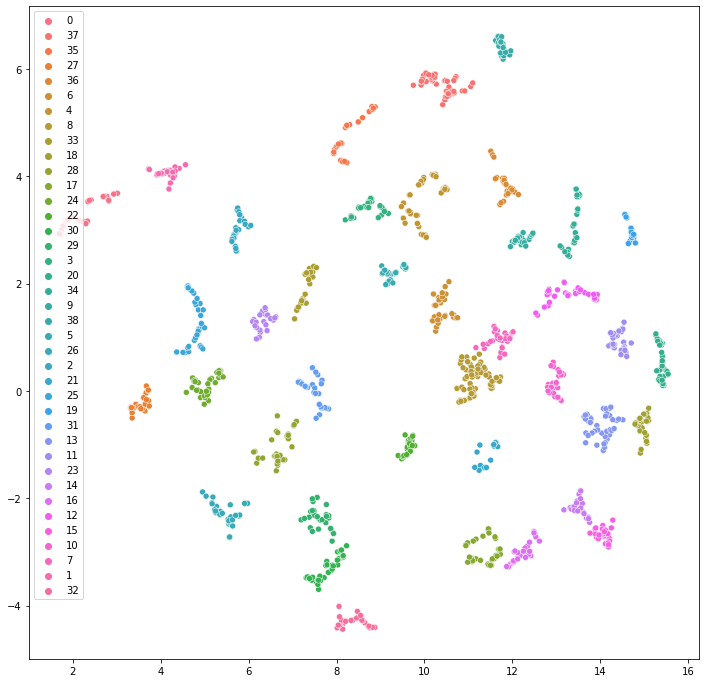

In [68]:
x2d = UMAP(n_neighbors=3, min_dist=0.01, metric='cosine', random_state=444).fit_transform(pca1)
optics = OPTICS(xi=0.07, min_cluster_size=0.01).fit(x2d)

fig, ax = plt.subplots(figsize=(12,12))
indices = [i for i, l in enumerate(optics.labels_) if l != -1]
ax = sns.scatterplot(x=x2d[:, 0].take(indices), y=x2d[:,1].take(indices), hue=[str(l) for l in optics.labels_ if l != -1])

In [ ]:
core_word_clusters = {}
for label, point, word in zip(optics.labels_, x2d, verbs):
  if label not in core_word_clusters:
    core_word_clusters[label] = []
  core_word_clusters[label].append(word)

del core_word_clusters[-1]

pprint(core_word_clusters)

In [70]:
with open('checkpoints/verbcls1.pkl', 'wb') as d:
  pickle.dump(core_word_clusters, d)

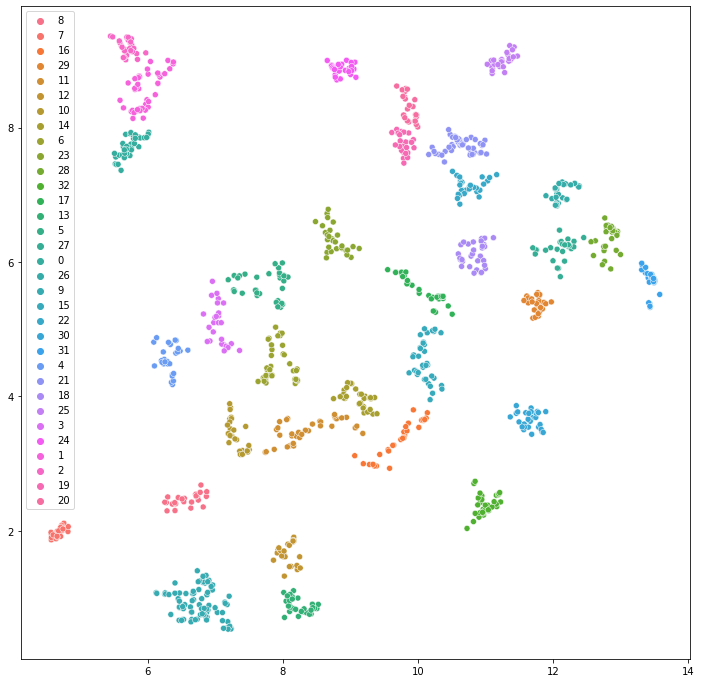

In [32]:
x2d = UMAP(n_neighbors=4, min_dist=0.01, metric='cosine', random_state=444).fit_transform(pca1)
optics = OPTICS(xi=0.05, min_cluster_size=0.01).fit(x2d)

fig, ax = plt.subplots(figsize=(12,12))
indices = [i for i, l in enumerate(optics.labels_) if l != -1]
ax = sns.scatterplot(x=x2d[:, 0].take(indices), y=x2d[:,1].take(indices), hue=[str(l) for l in optics.labels_ if l != -1])

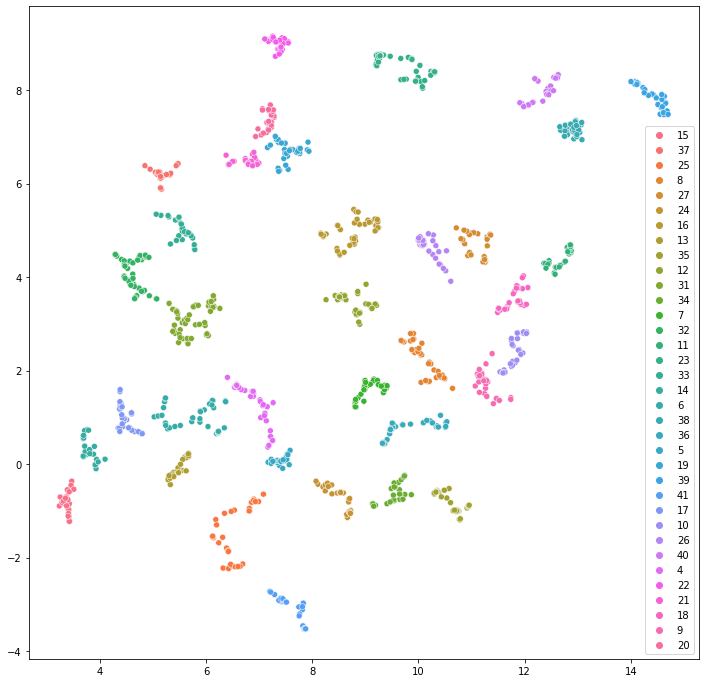

In [38]:
x2d = UMAP(n_neighbors=4, min_dist=0.01, metric='cosine', random_state=444).fit_transform(pca2)
optics = OPTICS(xi=0.05, min_cluster_size=0.01).fit(x2d)

fig, ax = plt.subplots(figsize=(12,12))
indices = [i for i, l in enumerate(optics.labels_) if l not in [3, 2, 1, 0, -1, 28, 29, 30]]
ax = sns.scatterplot(x=x2d[:, 0].take(indices), y=x2d[:,1].take(indices), hue=[str(l) for l in optics.labels_ if l not in [3, 2, 1, 0, -1, 28, 29, 30]])

## Subjects

## Adjectives